# Graphene Ring

#### Import the different "Package"

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import kwant
import math
from math import atan2, pi, sqrt, cos, sin
from cmath import exp
from types import SimpleNamespace
from collections import namedtuple

#### Fundamental constant 

In [2]:
h = 6.626069e-34    # Planck constant (Js)
e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)
a = 1 # new constant
param_syst = namedtuple("param_syst", "a t R_ext R_conge W W_L L_L magn_activated potential_activated")
param_pot=namedtuple("param_pot", "theta_min theta_max choice_pot")
choice_pot=namedtuple("choice_pot", "choice param_constant param_linear param_quadratic")
param_linear=namedtuple("param_linear", "phi_in_left phi_in_rigth V_left V_rigth V_mid")
# the tuple work as follow:
# param_pot: -theta_min: number (minimal angle for the potential region)
#            -theta_max: number (maximal angle for the potential region)
#            -choice_pot:-choice: "name" (of the potential, constant, linear, quadradic)
#                        -param_constant:"V_O"  (value of the potential, unique parameter of the potential)
#                        -param_linear:- "phi_in_left"
#                                      - "phi_in_rigth"
#                                      - "V_left"
#                                      - "V_rigth"
#                                      - "V_mid"
#                        -param_quadratic:- ""to be done 



#### Definition of the graphene function with some parameters

* R_ext is the external radius 
* W is the width of one ring arm
* W_L is the width of the lead
* L_L is the length of the lead starting from the outer circle


In [3]:
def potential_VG(pos,param_pot):
        x, y = pos
        ## work in  polar coordinate since it is a ring
        #r = sqrt(x**2 + y**2)
        theta = atan2(y,x)
        
         ##function Vg
        
        # constant 
        if param_pot.choice_pot.choice=='constant':
            VG=param_pot.choice_pot.param_constant
            return VG
            
        # linear 
        elif param_pot.choice_pot.choice=='linear':
            V_mid=param_pot.choice_pot.param_linear.V_mid
            V_left=param_pot.choice_pot.param_linear.V_left
            V_rigth=param_pot.choice_pot.param_linear.V_rigth
            phi_in_left=param_pot.choice_pot.param_linear.phi_in_left
            phi_in_rigth=param_pot.choice_pot.param_linear.phi_in_rigth
            phi_min=param_pot.theta_min
            phi_max=param_pot.theta_max
            slope_left=(V_mid-V_left)/(phi_in_left-phi_min)
            slope_rigth=(V_mid-V_rigth)/(phi_in_rigth-phi_max)
            if phi_min<theta<phi_in_left:
                return V_left+slope_left*(theta-phi_min)
            elif phi_in_rigth<theta<phi_max:
                return V_rigth+slope_rigth*(theta-phi_max)
            else: 
                return V_mid
            #print('still not done, choose 1 ')
            #return VG
            
            
        # quadratic
        elif param_pot.choice_pot.choice=='quadratic':
            VG=0
            #print('still not done, choose 1 ')
            return VG
        else: 
            return 0
# definition of the potential. Take the position of the site, check in which arm we 
    # are. then depending on the arm we are, the function calls another function that 
    # computes the potential depending on the choice of the form 
def potential(site,param_pot_1,param_pot_2):

        x, y = site.pos
        ## work in  polar coordinate since it is a ring
        #r = sqrt(x**2 + y**2) # in the first place we dont considered the position along the radial direction 
        # since we assume a constant potential in the width of the arm
        theta = atan2(y,x)
        if 0<y :
            if   param_pot_1.theta_min <theta< param_pot_1.theta_max:
                return  potential_VG(site.pos,param_pot_1)
            else: 
                return 0
        elif 0>y: 
            if   param_pot_2.theta_min <theta< param_pot_2.theta_max:
                return  potential_VG(site.pos,param_pot_2)
            else: 
                return 0
        else:
            return 0
def make_system(param, param_pot_1,param_pot_2):
    a=param.a
    t=param.t
    R_ext=param.R_ext
    W=param.W
    W_L=param.W_L
    L_L=param.L_L
    magn_activated=param.magn_activated
    potential_activated=param.potential_activated
    R_conge=param.R_conge
    graphene = kwant.lattice.honeycomb(a,norbs=1)
    a_lat, b_lat = graphene.sublattices
    sys = kwant.Builder()
    # definition geometry (ring)
    def circle(pos): return (pos[0]**2 + pos[1]**2 <R_ext**2  and pos[0]**2 + pos[1]**2 >(R_ext-W)**2) \
                            or ((R_ext-W/2)<pos[0]<(R_ext+L_L )
                            and abs(pos[1])<W_L/2) \
                            or (-(R_ext-W/2)>pos[0]>-(R_ext+L_L) 
                            and abs(pos[1])<W_L/2) 
    # definition geometry (ring smooth)
    def circle_smooth(pos): 
        dist_center_x=sqrt(R_ext**2-(R_conge+W_L/2)**2)+R_conge
        dist_center_y=R_conge+W_L/2
        #(x-x_center)**2+(y-y_center)**2=R_conge**2
        return (pos[0]**2 + pos[1]**2 <R_ext**2  and pos[0]**2 + pos[1]**2 >(R_ext-W)**2) \
                            or ((R_ext-W/2)<pos[0]<(R_ext+L_L )
                            and abs(pos[1])<W_L/2) \
                            or (-(R_ext-W/2)>pos[0]>-(R_ext+L_L) 
                            and abs(pos[1])<W_L/2) \
                            or (  ((pos[0]-dist_center_x)**2+(pos[1]-dist_center_y)**2>R_conge**2 )
                            and (W_L/2<pos[1]<(W_L/2+R_conge) and dist_center_x-R_conge<pos[0]<dist_center_x))\
                            or (  ((pos[0]+dist_center_x)**2+(pos[1]-dist_center_y)**2>R_conge**2 )
                            and (W_L/2<pos[1]<(W_L/2+R_conge) and -dist_center_x<pos[0]<-dist_center_x+R_conge))\
                            or (  ((pos[0]-dist_center_x)**2+(pos[1]+dist_center_y)**2>R_conge**2 )
                            and (-W_L/2-R_conge<pos[1]<-W_L/2 and dist_center_x-R_conge<pos[0]<dist_center_x))\
                            or (  ((pos[0]+dist_center_x)**2+(pos[1]+dist_center_y)**2>R_conge**2 )
                            and (-W_L/2-R_conge<pos[1]<-W_L/2 and -dist_center_x<pos[0]<-dist_center_x+R_conge))
    # onsite energy
    if potential_activated==0:
       sys[graphene.shape(circle_smooth, (R_ext-W/2,0))] = 0 
    elif potential_activated==1:
        sys[graphene.shape(circle, (R_ext-W/2,0))]=potential
    else:
         print('Wrong input parameter for the potential')
    
    # definition hopping for magnetic field        
    def hopping(site_i, site_j, phi,param_pot_1,param_pot_2):
        xi, yi = site_i.pos
        xj, yj = site_j.pos
        return -t * exp(-0.5j*phi/(h/e)/pi*(xi-xj)*(yi+yj))

    hoppings = (((0, 0), a_lat, b_lat), ((0, 1), a_lat, b_lat), ((-1, 1), a_lat, b_lat))
    
    # hopping term
    if magn_activated==0:
         sys[[kwant.builder.HoppingKind(*hoppingg) for hoppingg in hoppings]] = -t
    
    elif magn_activated==1:
        sys[graphene.neighbors()] = hopping
        
    else:
        print('Wrong input parameter for the magnetic field')
   

    
    
    # lead 
    sym=kwant.TranslationalSymmetry(graphene.vec((1,0)))
    def lead_shape(R): return abs(R[1]) < W_L/2
    
    Hlead =kwant.Builder(sym)
    #if potential_activated==0:
    Hlead[graphene.shape(lead_shape,(0,0) )]=0
    #elif potential_activated==1:
    #    Hlead[graphene.shape(lead_shape,(0,0) )]=potential
    #else:
    # print('Wrong input parameter for the potential')
    
    if magn_activated==0:
         Hlead[graphene.neighbors()]=-t
    
    elif magn_activated==1:
        Hlead[graphene.neighbors()] = hopping
        
    else:
        print('Wrong input parameter for the magnetic field')
   
    
    
    sys.attach_lead(Hlead)
    sys.attach_lead(Hlead.reversed())
    
    
    return sys

#### Creation of the physical graphene ring

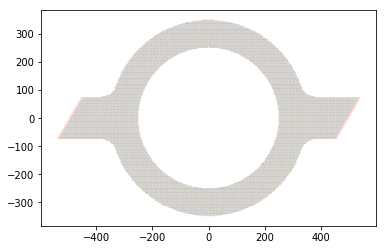

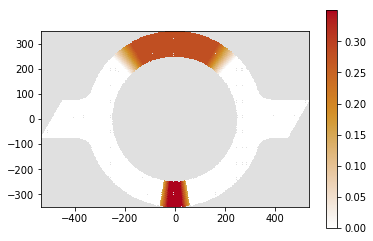

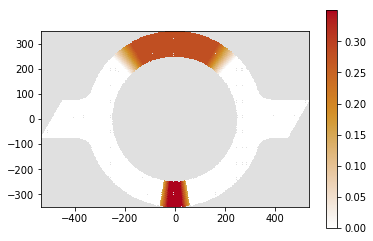

In [4]:
#n2D=1.2e16
#scaling_fact=25
scaling_fact=20
a0=0.246
a=a0*scaling_fact
t0=2.8
t=t0/scaling_fact


param = param_syst(a=a0*scaling_fact, t=t,R_ext=350,R_conge=75, W=100,W_L=150,L_L=100,magn_activated=0,potential_activated=0)

param_constant_1=2*t
param_constant_2=1*t
param_linear_1=param_linear( phi_in_left=60/180*pi, phi_in_rigth=120/180*pi, V_left=0, V_rigth=0, V_mid=2*t)
param_linear_2=param_linear( phi_in_left=-95/180*pi, phi_in_rigth=-85/180*pi, V_left=1*t, V_rigth=1*t, V_mid=2.5*t)
param_quadratic_1=0
param_quadratic_2=0
choice_pot_1=choice_pot( choice='linear', param_constant=param_constant_1, param_linear=param_linear_1, param_quadratic=param_quadratic_1)
choice_pot_2=choice_pot( choice='linear', param_constant=param_constant_2, param_linear=param_linear_2, param_quadratic=param_quadratic_2)

param_pot_1=param_pot(theta_min=45/180*pi,theta_max=135/180*pi,choice_pot=choice_pot_1)
param_pot_2=param_pot(theta_min=-100/180*pi,theta_max=-80/180*pi,choice_pot=choice_pot_2)


H=make_system(param,param_pot_1,param_pot_2)
kwant.plot(H)

Hf=H.finalized()
vals=[potential(Hf.sites[n], param_pot_1,param_pot_2) for n in range(Hf.graph.num_nodes)]
kwant.plotter.map(Hf, vals)


## Analysis of the transmission

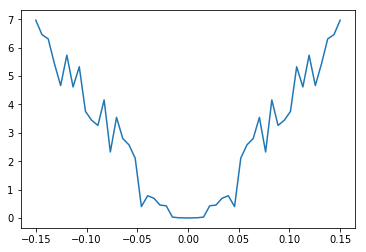

In [8]:
scaling_fact=15
#n2D=1.2e16
#scaling_fact=25
a0=0.246
a=a0*scaling_fact
t0=2.8
t=t0/scaling_fact

get_ipython().magic('matplotlib inline')
param = param_syst(a=a0*scaling_fact, t=t,R_ext=350,R_conge=0, W=100,W_L=150,L_L=100,magn_activated=0,potential_activated=0)

param_constant_1=2*t
param_constant_2=1*t
param_linear_1=param_linear( phi_in_left=60/180*pi, phi_in_rigth=120/180*pi, V_left=0, V_rigth=0, V_mid=2*t)
param_linear_2=param_linear( phi_in_left=-120/180*pi, phi_in_rigth=-60/180*pi, V_left=0, V_rigth=0, V_mid=2*t)
param_quadratic_1=0
param_quadratic_2=0
choice_pot_1=choice_pot( choice='linear', param_constant=param_constant_1, param_linear=param_linear_1, param_quadratic=param_quadratic_1)
choice_pot_2=choice_pot( choice='linear', param_constant=param_constant_2, param_linear=param_linear_2, param_quadratic=param_quadratic_2)

param_pot_1=param_pot(theta_min=45/180*pi,theta_max=135/180*pi,choice_pot=choice_pot_1)
param_pot_2=param_pot(theta_min=-70/180*pi,theta_max=-45/180*pi,choice_pot=choice_pot_2)


H=make_system(param,param_pot_1,param_pot_2)

Hf=H.finalized()


E = np.linspace(-0.15,0.15,50)

T2 = []
for x in E:
    smatrix = kwant.smatrix(Hf, energy = x,args=[param_pot_1, param_pot_2])
    T = smatrix.transmission(1,0)
    T2.append(T)
 
plt.plot(E,T2)    

In [ ]:
scaling_fact=20
#n2D=1.2e16
#scaling_fact=25
a0=0.246
a=a0*scaling_fact
t0=2.8
t=t0/scaling_fact


## magnetic field 


AB oscillation have a period given by 
Detlta_B=h_bar/(e*R_mean^2)


In [7]:
param = param_syst(a=a0*scaling_fact, t=t,R_ext=350,R_conge=0, W=100,W_L=150,L_L=100,magn_activated=1,potential_activated=0)
param_constant_1=2*t
param_constant_2=1*t
param_linear_1=param_linear( phi_in_left=60/180*pi, phi_in_rigth=120/180*pi, V_left=0, V_rigth=0, V_mid=2*t)
param_linear_2=param_linear( phi_in_left=-120/180*pi, phi_in_rigth=-60/180*pi, V_left=0, V_rigth=0, V_mid=2*t)
param_quadratic_1=0
param_quadratic_2=0
choice_pot_1=choice_pot( choice='linear', param_constant=param_constant_1, param_linear=param_linear_1, param_quadratic=param_quadratic_1)
choice_pot_2=choice_pot( choice='linear', param_constant=param_constant_2, param_linear=param_linear_2, param_quadratic=param_quadratic_2)

param_pot_1=param_pot(theta_min=45/180*pi,theta_max=135/180*pi,choice_pot=choice_pot_1)
param_pot_2=param_pot(theta_min=-135/180*pi,theta_max=-45/180*pi,choice_pot=choice_pot_2)



param_pot_1=param_pot(theta_min=45/180*pi,theta_max=135/180*pi,choice_pot=choice_pot_1)
param_pot_2=param_pot(theta_min=-135/180*pi,theta_max=-45/180*pi,choice_pot=choice_pot_2)

#param_pot_1=param_pot(theta_min=45/180*pi,theta_max=135/180*pi,choice_VG='constant',VG=2*t)
#param_pot_2=param_pot(theta_min=-135/180*pi,theta_max=-45/180*pi,choice_VG='constant',VG=0)



H=make_system(param,param_pot_1,param_pot_2)

H_mf=H.finalized()

#### For a realistic value of phi ####
#B = 0.05 # (Tesla) value of the magnetic field (well, the magnetic flux density for the purists among you)

#phi = B * a**2 *sqrt(3)/2)/scaling_fact**2 # with 'a' being the scale value 

E=0.1
N = 200 # number of magnetic field values
Bmax = 0.05 # higher magnetic field
Bs = np.linspace(-Bmax, Bmax, N) # vector of the magnetic fields

G = np.zeros([N,1])

for i,B in enumerate(Bs):
    phi = B * a**2 *sqrt(3)/2 * (1e-18)
    smatrix = kwant.smatrix(H_mf, energy = E,args=[phi,param_pot_1,param_pot_2] ) # transmission matrix (here this)
    T = smatrix.transmission(1, 0) # transmission value obtained from the left lead towards the right lead
    G[i] = T
    
plt.plot(Bs,G)

plt.xlabel('Magnetic field (T)')
plt.ylabel('Transmission (2e²/h)')

plt.show()
#data = []
#phis = np.linspace(0,1.,10)
#for phi in phis:
#    smatrix = kwant.smatrix(Hf, 3.3,args=[phi])
#    data.append(smatrix.transmission(1, 0))
#pyplot.plot(phis, data,'o');
#pyplot.xlabel('$\phi = BS/(h/e)$')
#pyplot.ylabel('g in unit of $(2e^2/h)$');
#pyplot.title('Aharonov-Effect')
